In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.utils import read_df

# Datasets

Inicialmente, vamos dar uma olhada nos datasets a serem analisados.

In [2]:
datasets_df = pd.read_csv('data/DataSummary.csv')
datasets_df.describe()

,ID,Train,Test,Class,Length,ED (w=0),DTW (w=100),Default rate
count,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000
mean,64.500000,473.085938,1020.335938,8.734375,534.539062,0.313754,0.272256,0.661984
std,37.094474,1107.392554,2001.825038,12.028499,563.047192,0.203079,0.189050,0.213373
min,1.000000,16.000000,20.000000,2.000000,15.000000,0.000000,0.000000,0.107900
25%,32.750000,53.750000,139.000000,2.000000,144.000000,0.152175,0.134325,0.485650
50%,64.500000,190.500000,316.000000,4.000000,344.000000,0.288050,0.246200,0.666700
75%,96.250000,400.000000,870.750000,10.000000,657.750000,0.434575,0.366175,0.871600
max,128.000000,8926.000000,16800.000000,60.000000,2844.000000,0.942300,0.894200,0.983300


Para facilitar a visualização, selecionaremos alguns datasets, de tamanhos (considerando o conjunto de treino, número de classes e comprimento das séries) variados.

In [3]:
df_names = ["WordSynonyms", "SemgHandSubjectCh2", "PLAID", "MelbournePedestrian", "ChlorineConcentration", "MelbournePedestrian"]
new_df = datasets_df.loc[datasets_df['Name'].isin(df_names)].set_index('Name')
new_df.loc[df_names].reset_index().drop(columns=['ID', 'DTW (learned_w) ', 'Data donor/editor', 'Default rate'])

,Name,Type,Train,Test,Class,Length,ED (w=0),DTW (w=100)
0,WordSynonyms,Image,267,638,25,270,0.3824,0.3511
1,SemgHandSubjectCh2,Spectrum,450,450,5,1500,0.5956,0.2733
2,PLAID,Device,537,537,11,1344,0.4767,0.1639
3,MelbournePedestrian,Traffic,1194,2439,10,24,0.1525,0.2091
4,ChlorineConcentration,Sensor,467,3840,3,166,0.3500,0.3516
5,MelbournePedestrian,Traffic,1194,2439,10,24,0.1525,0.2091


### MDS

Para facilitar a visualização de como as séries temporais estão dispostas (considerando a distância euclidiana entre elas), podemos utilizar um Multidimensional Scaling (MDS) em cada dataset.

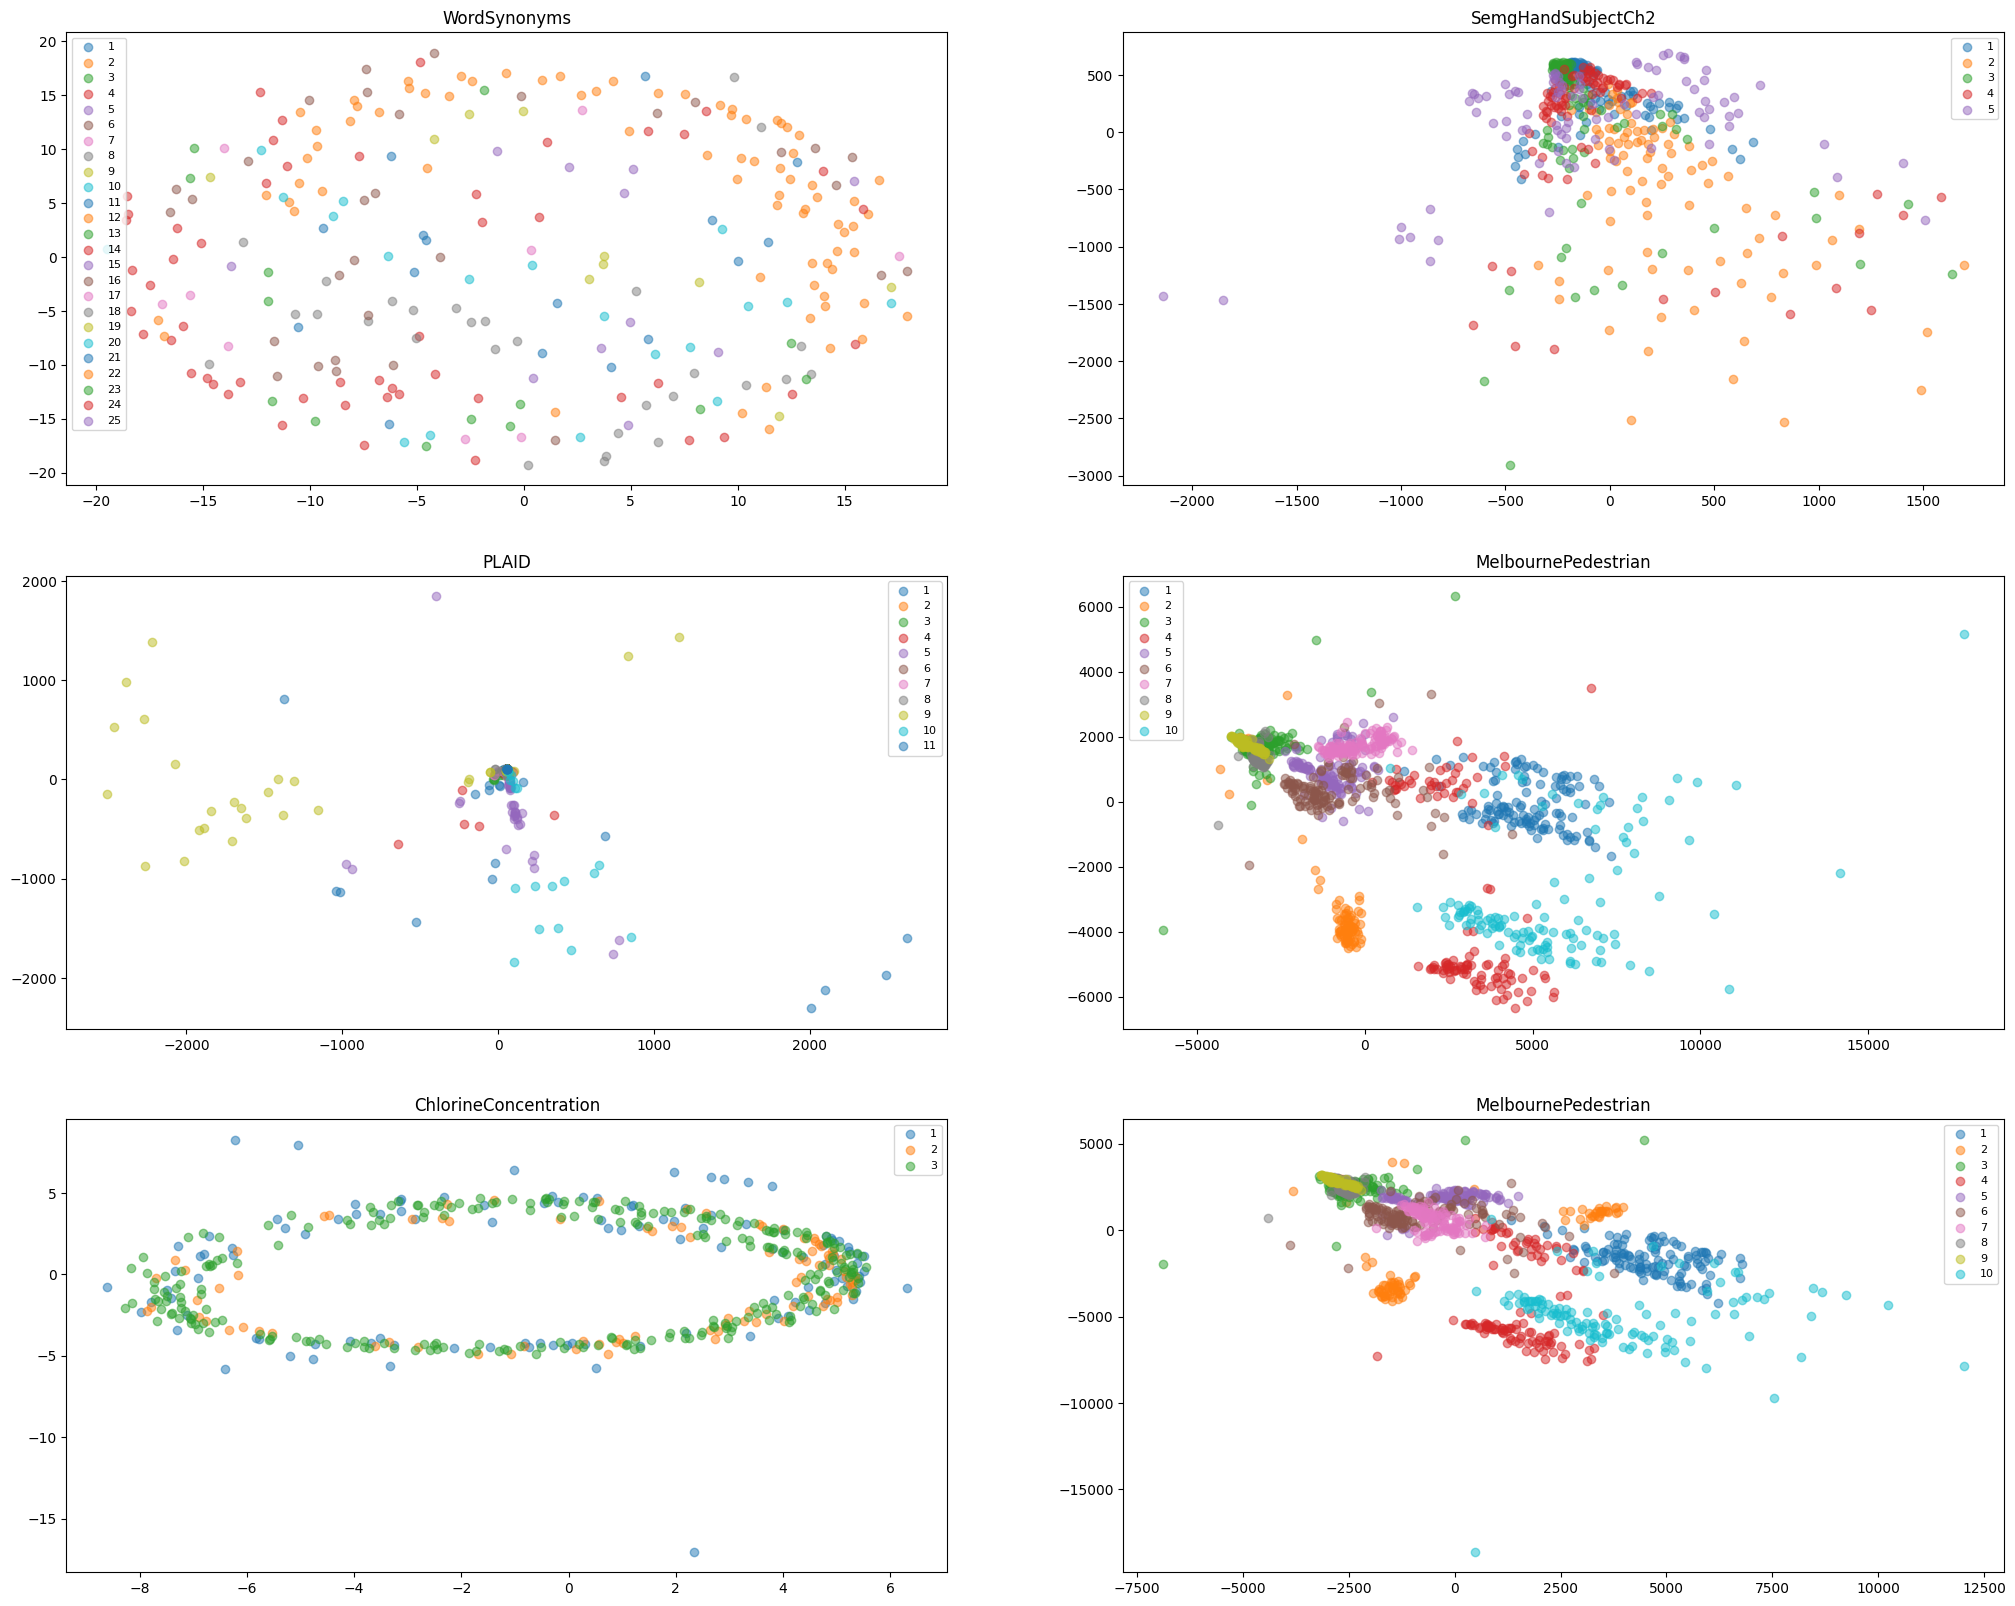

In [4]:
from sklearn.manifold import MDS

fig, axes = plt.subplots(3, 2, figsize=(25, 20))

def scatter_points(df_name, ax):
    X, y, X_test, y_test, df_errors = read_df(df_name)
    embedding = MDS(n_components=2)
    X_t = embedding.fit_transform(X)

    for cur_y in np.unique(y):
        ax.scatter(X_t[y==cur_y,0], X_t[y==cur_y,1], alpha=0.5)
    ax.legend(np.unique(y), fontsize=8, title_fontsize=8)
    ax.title.set_text(df_name)
    
for idx, df_name in enumerate(df_names):
    scatter_points(df_name, axes.flatten()[idx])
    
plt.show()

A primeira vista, alguns datasets não apresentam nenhum agrupamento considerável com relação à distância euclidiana, porém outros apresentam.

### MDS Interativo

In [8]:
from jupyter_dash import JupyterDash
from dash import dcc, html, Input, Output, no_update
import seaborn as sns
import plotly.graph_objects as go

X, y, X_test, y_test, df_errors = read_df("MelbournePedestrian")
embedding = MDS(n_components=2)
X_t = embedding.fit_transform(X)

df_plot = pd.DataFrame({
        "x": X_t[:,0],
        "y": X_t[:,1],
        "l": y
    })

palette = sns.color_palette("colorblind")

scatter_points = [
    go.Scatter(
        name=c,
        x=d["x"],
        y=d["y"],
        mode="markers",
        marker=dict(
            color=f'rgb{palette[c%len(palette)]}',
            line={"color": "#444"},
            reversescale=True,
            sizeref=45,
            sizemode="diameter",
            opacity=0.6,
        )
    )
    for c, d in df_plot.groupby("l")
]

layout = go.Layout(showlegend=True)
fig = go.FigureWidget(data=scatter_points, layout=layout)

# turn off native plotly.js hover effects - make sure to use
# hoverinfo="none" rather than "skip" which also halts events.
fig.update_traces(hoverinfo="none", hovertemplate=None)

fig.update_layout(
    plot_bgcolor='rgba(255,255,255,0.1)'
)

app = JupyterDash(__name__)

app.layout = html.Div([
    dcc.Graph(id="graph", figure=fig, clear_on_unhover=True),
    dcc.Tooltip(id="graph-tooltip"),
])


@app.callback(
    Output("graph-tooltip", "show"),
    Output("graph-tooltip", "bbox"),
    Output("graph-tooltip", "children"),
    Input("graph", "hoverData"),
)
def display_hover(hoverData):
    if hoverData is None:
        return False, no_update, no_update

    # demo only shows the first point, but other points may also be available
    pt = hoverData["points"][0]
    bbox = pt["bbox"]
    num = pt["pointNumber"]
    idx = pt["curveNumber"] + 1
    
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=np.array(range(len(X[num]))), y=X[num],
        line_color=f'rgb{palette[idx%len(palette)]}',
    ))
    fig.update_yaxes(visible=False, showticklabels=False)
    fig.update_xaxes(visible=False, showticklabels=False)
    fig.update_layout(
        showlegend=False,
        plot_bgcolor="white",
        margin=dict(t=10,l=10,b=10,r=10),
        height=100,
        width=120
    )

    children = [
        html.Div(children=[
            html.H4(f"#{num}"),
            html.Div(f"Label {idx}"),
            dcc.Graph(figure=fig)
        ],
        style={'width': '120px', 'white-space': 'normal'})
    ]

    return True, bbox, children


if __name__ == "__main__":
    app.run_server(debug=True, mode='inline')

/mnt/c/Users/AndreFakhoury/Documents/GitHub/time-series-opf/venv/lib/python3.8/site-packages/jupyter_dash/jupyter_app.py:139: UserWarning:

The 'environ['werkzeug.server.shutdown']' function is deprecated and will be removed in Werkzeug 2.1.



# Optimum-Path Forest

Nosso objetivo é utilizar o classificador supervisionado Optimum-Path Forest (OPF) para atribuir rótulos a séries temporais desconhecidas, a partir de um conjunto de treinamento. O pipeline de atividades será visto a seguir.

### 1. Séries temporais

In [89]:
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.graph_objects as go

palette = sns.color_palette("colorblind")
palette = [palette[1], palette[-1]]

X, y, X_test, y_test, df_errors = read_df("BirdChicken")
X = [X[7], X[8], X[9], X[12], X[10]]
y = [y[7], y[8], y[9], y[12], y[10]]

fig = make_subplots(rows=len(X), cols=1, subplot_titles=("1", "2", "3", "4", "5"))

for i in range(len(X)):
    fig.add_trace(go.Scatter(
        x=np.array(range(len(X[i]))), y=X[i],
        line_color=f'rgb{palette[y[i]%len(palette)]}'
    ), row=i+1, col=1)

fig.update_yaxes(visible=False, showticklabels=False)
fig.update_xaxes(visible=False, showticklabels=False)
fig.update_layout(
    showlegend=False,
    font_color="black",
    plot_bgcolor="white",
    margin=dict(t=20,l=10,b=10,r=10),
    height=300,
    width=300
)
for i in range(5):
    fig.layout.annotations[i].update(x=0.0, font={'size': 14})

fig.show()

### 2. Grafo completo

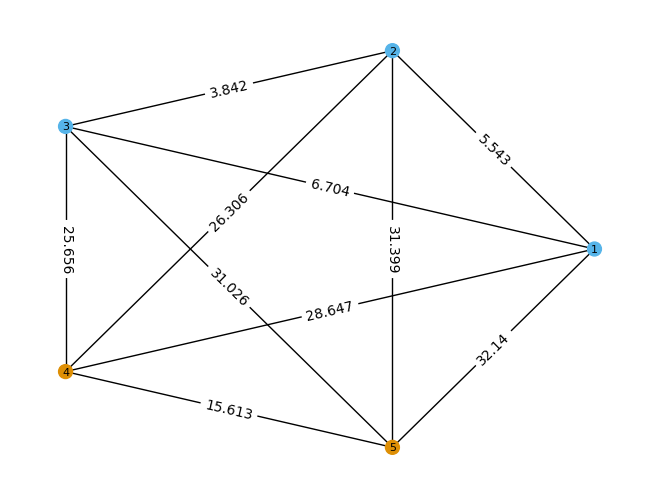

In [90]:
import networkx as nx
from src.py_opf import OptimumPathForestClassifier

opf = OptimumPathForestClassifier()
opf.fit(X, y)

G = nx.Graph(directed=False)
G.add_nodes_from(list(range(1, len(X)+1)))

for u in range(len(X)):
    for v in range(u+1, len(X)):
        G.add_edge(u+1, v+1, weight=round(opf.F(X[u], X[v]), 3))

pos=nx.circular_layout(G)
node_color = [palette[y[i]%len(palette)] for i in range(len(X))]

nx.draw(G, node_size=100, pos=pos, with_labels=True, node_color=node_color, font_size=8)
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels);

### 3. Escolha dos protótipos

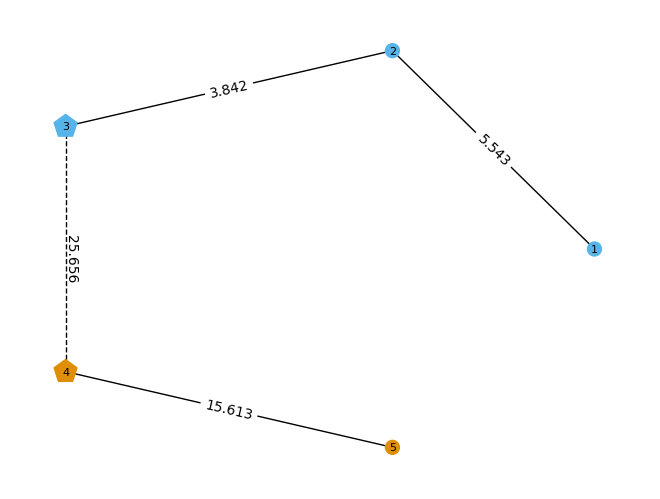

In [91]:
opf = OptimumPathForestClassifier()
opf.fit(X, y)

G = nx.Graph(directed=False)
G2 = nx.Graph(directed=False)
G.add_nodes_from(list(range(1, len(X)+1)))
G2.add_nodes_from([3, 4])

G2.add_edge(3, 4, weight=round(opf.F(X[2], X[3]), 3))

for u in range(len(X)):
    v = opf.parent[u]
    if v != -1:
        G.add_edge(u+1, v+1, weight=round(opf.F(X[u], X[v]), 3))

node_color = [palette[y[i]%len(palette)] for i in range(len(X))]

nx.draw(G, node_size=100, pos=pos, with_labels=True, node_color=node_color, font_size=8)
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels);

labels = nx.get_edge_attributes(G2,'weight')
nx.draw_networkx_edge_labels(G2, {k: [v[0]+0.02, v[1]+0.07] for k, v in pos.items()}, verticalalignment='top', edge_labels=labels);
nx.draw_networkx_edges(G2, pos, style='dashed')
nx.draw_networkx_nodes(G2, pos, node_shape='p', node_color=[palette[1], palette[0]]);

### 4. Conquista dos rótulos

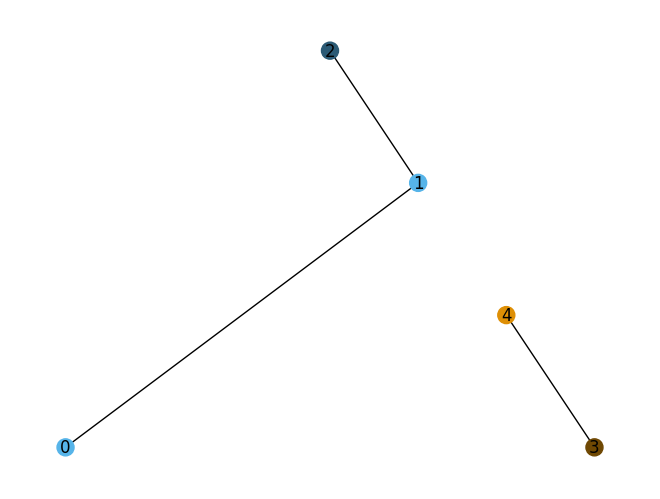

In [93]:
opf = OptimumPathForestClassifier()
opf.fit(X, y)

import networkx as nx
G = nx.Graph(directed=True)
G.add_nodes_from(list(range(len(X))))
G.add_weighted_edges_from([(opf.parent[u], u, opf.F(X[u], X[opf.parent[u]])) for u in range(len(X)) if opf.parent[u] != -1])
nx.set_node_attributes(G, {u: X_t[u] for u in range(len(X))}, "pos")

color = [palette[y[u]%len(palette)] for u in range(len(X))]
for u in opf.prototypes:
    color[u] = color[u][0]/2, color[u][1]/2, color[u][2]/2

pos = nx.planar_layout(G)
nx.draw(G, pos=pos, node_size=150, node_color=color, with_labels=True)

### 5. Teste

# Resultados

In [ ]:
df = pd.read_csv('results/all_errors.csv')
df = df[['1NN-DTW', 'OPF-DTW', '1NN-ED', 'OPF-ED']]
df.describe()

### Teste de Hipótese (Nemenyi)

In [ ]:
import Orange
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

avranks = df.rank(axis=1,ascending=True).mean().values
cd = Orange.evaluation.compute_CD(avranks, df.shape[0], 
                                  alpha="0.05", test="nemenyi")
Orange.evaluation.graph_ranks(avranks, df.keys(), 
                              cd=cd, width=7, textspace=1.5)
plt.show();

### Boxplot

Boxplot + Scatter + Jitter

In [ ]:
vals, names, xs = [],[],[]
for i, col in enumerate(df.columns):
    vals.append(df[col].values)
    names.append(col)
    xs.append(np.random.normal(i + 1, 0.04, df[col].values.shape[0]))  # adds jitter to the data points - can be adjusted

boxplot = plt.boxplot(vals, labels=names)
for median in boxplot['medians']:
    median.set_color('black')
palette = sns.color_palette("colorblind")[1:5]
for x, val, c in zip(xs, vals, palette):
    plt.scatter(x, val, alpha=0.25, color=c)
plt.ylabel('Error')
plt.show()

### Ranking dos classificadores

In [ ]:
f = {c: 0 for c in df.columns}
for row in np.array(df):
    for idx, clf_name in enumerate(df.columns):
        if row[idx] == np.min(row):
            f[clf_name] += 1

fig, ax = plt.subplots()

# Save the chart so we can loop through the bars below.
bars = ax.bar(*zip(*f.items()), color=palette)

# Axis formatting.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)

# Add text annotations to the top of the bars.
for bar in bars:
  ax.text(
      bar.get_x() + bar.get_width() / 2,
      bar.get_height() + 0.3,
      round(bar.get_height(), 1),
      horizontalalignment='center',
      color=bar.get_facecolor(),
      weight='bold'
  )

# Add labels and a title. Note the use of `labelpad` and `pad` to add some
# extra space between the text and the tick labels.
ax.set_xlabel('Classificador', labelpad=15, color='#333333')
ax.set_ylabel('Quantidade de datasets', labelpad=15, color='#333333')
ax.set_title('Quantas vezes cada classificador atingiu a melhor acurácia em um dataset', pad=15, color='#333333',
             weight='bold')

fig.tight_layout()
